In [1]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation"



/Users/jessica/mambaforge/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_adata_cd4= sc.read_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed.h5ad")
raw_adata_cd4.var_names_make_unique()
print(raw_adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
raw_adata_cd4.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    9527
Regulatory T cell                   267
CCR6+ memory CD4 T cell             222
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

#### 1. Batch integration with scVI

In [4]:
scvi.model.SCVI.setup_anndata(raw_adata_cd4, layer="counts", batch_key="pica_id")

In [5]:
model = scvi.model.SCVI(raw_adata_cd4, n_layers=2, n_latent=30, gene_likelihood="nb")

In [6]:
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [2:34:50<00:00, 18.46s/it, v_num=1, train_loss_step=7.86e+3, train_loss_epoch=7.81e+3]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [2:34:50<00:00, 23.23s/it, v_num=1, train_loss_step=7.86e+3, train_loss_epoch=7.81e+3]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
saving figure to file /Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation/umap_scvi_integrated_umap.png


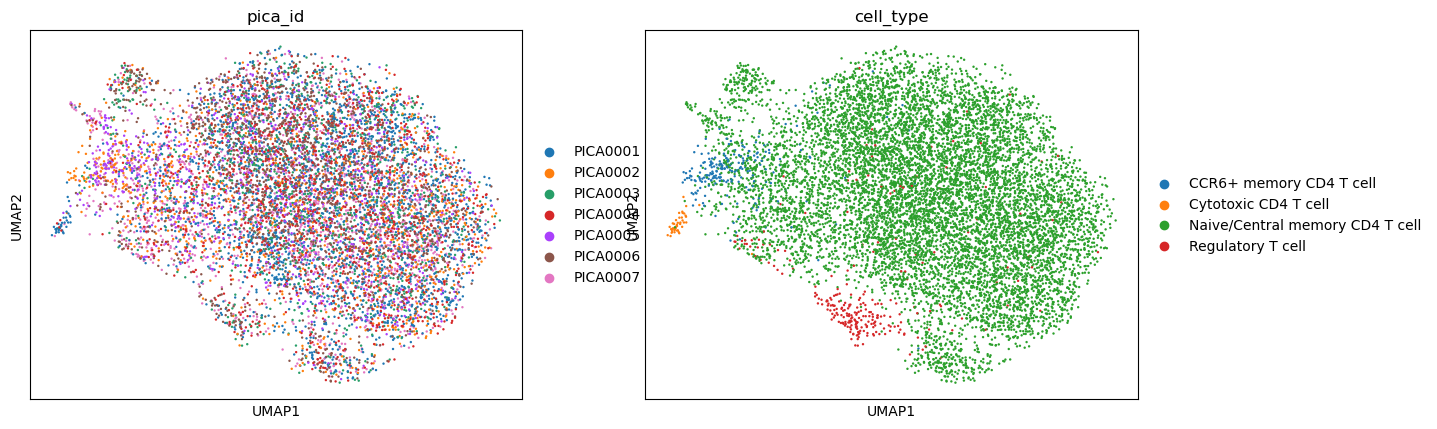

In [7]:
raw_adata_cd4.obsm["X_scVI"] = model.get_latent_representation()

#  latent representation 
sc.pp.neighbors(raw_adata_cd4, use_rep="X_scVI")
sc.tl.umap(raw_adata_cd4)


sc.pl.umap(raw_adata_cd4, color=[ "pica_id", 'cell_type'], save="_scvi_integrated_umap.png")

saving figure to file /Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation/umap_scvi_qc.png


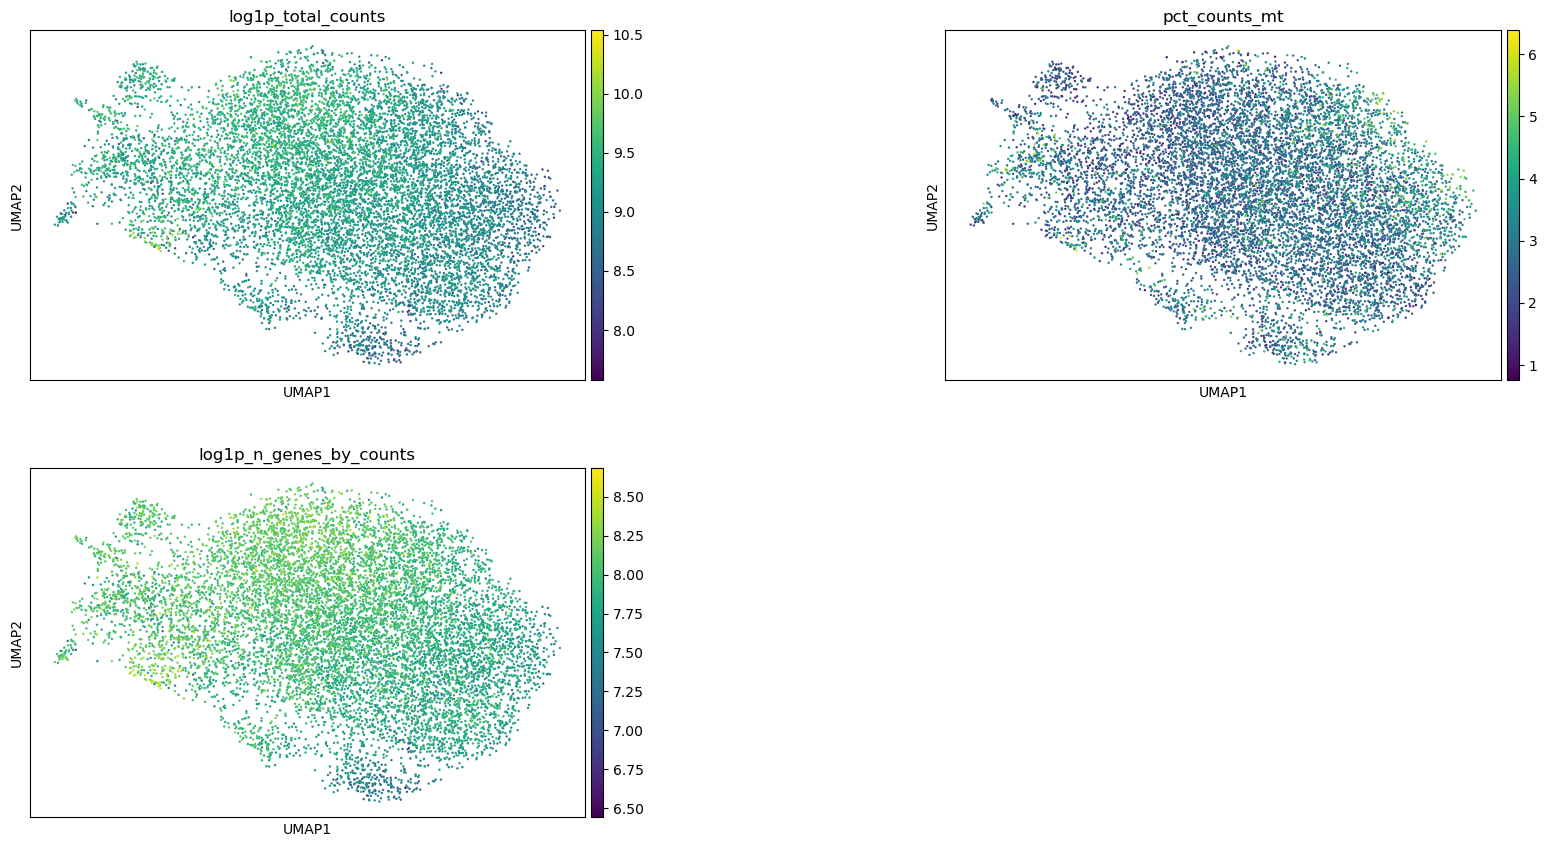

In [8]:
sc.pl.umap(
    raw_adata_cd4,
    color=["log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    save="_scvi_qc.png"
)

In [9]:
# Save the scVI integrated batch adata
raw_adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_scVI.h5ad", compression='gzip')

#### 2. Clustering
- resolutions
- known marker genes to see if they align with cluster size

In [11]:
# Test different resolutions for Leiden clustering
# Higher resolution will result in more clusters, lower resolution will result in fewer clusters
for res in [ 0.5, 1.0, 1.5, 2.0]:
    sc.tl.leiden(
        raw_adata_cd4, key_added=f"leiden_res_{res:3.1f}", resolution=res, flavor="igraph"
    )

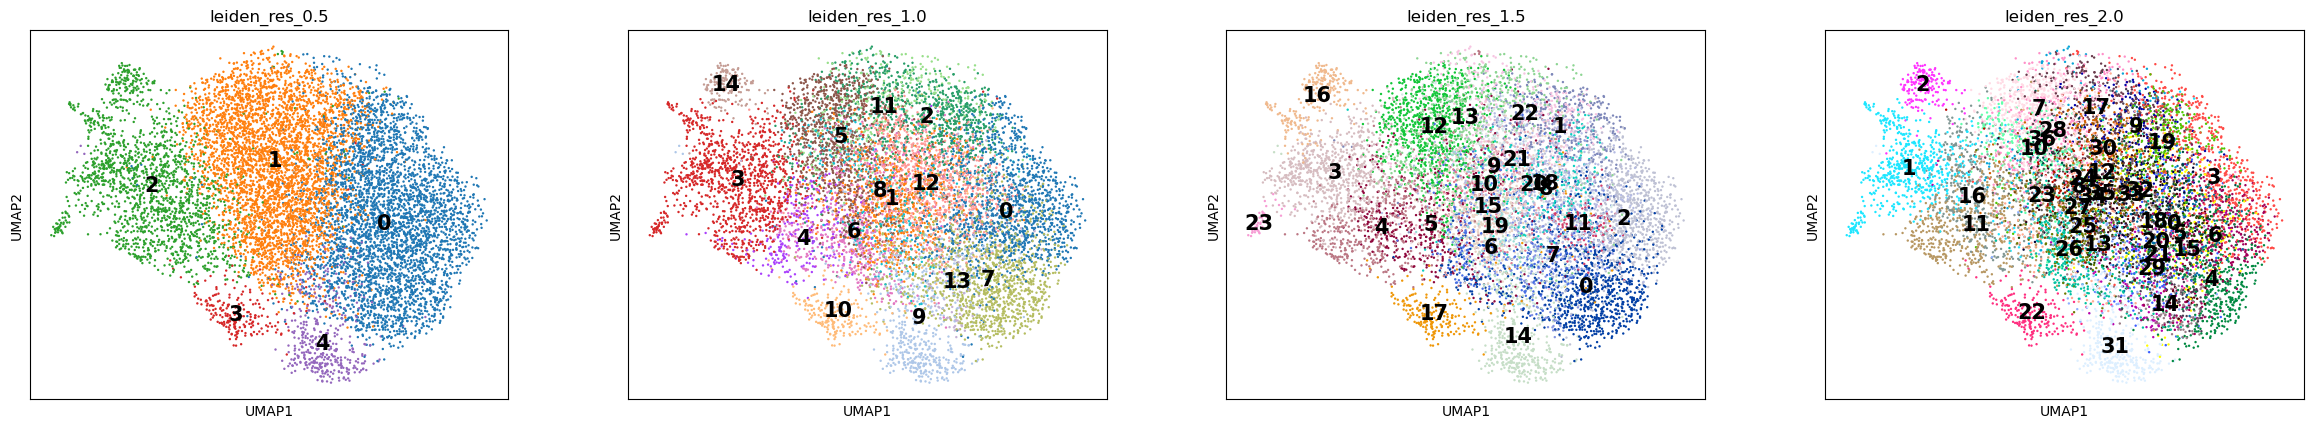

In [12]:
sc.pl.umap(
    raw_adata_cd4,
    color=[ "leiden_res_0.5", "leiden_res_1.0","leiden_res_1.5", "leiden_res_2.0"],
    legend_loc="on data", legend_fontsize = 15
)

In [13]:
# Save the clustered adata
raw_adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_cluster.h5ad", compression='gzip')
print(raw_adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 
'cell_type_colors', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 
'leiden_res_0.5_colors', 'leiden_res_1.0_colors', 'leiden_res_1.5_colors', 'leiden_res_2.0_colors'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [49]:
raw_adata_cd4= sc.read_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_cluster.h5ad")
print(raw_adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden_res_0.5', 'leiden_res_0.5_colors', 
'leiden_res_1.0', 'leiden_res_1.0_colors', 'leiden_res_1.5', 'leiden_res_1.5_colors', 'leiden_res_2.0', 
'leiden_res_2.0_colors', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

##### 3. CD4 subset validation

In [50]:
broad_marker_genes = {
    "B cell": ["BLNK", "CD19", "CD79A", "CD79B", "MS4A1", "CD37", "CD79A"],
    "Plasmablast": ["CD19", "CD24", "CD38"], # experiment
    "Dendritic cell": ["CLEC4C", "IL3RA", "NRP1", "CD1C", "CST3", "FCER1A", "CD123", "GZMB"],
    "Endothelial cell": ["CDH5", "SELE", "VWF"],
    "Fibroblast": ["COL1A1", "COL3A1", "FAP", "THY1"],
    'Neutrophils': ['S100A8', 'S100A9', 'CEACAM8', 'ELANE', 'CSF3R', 'MPO'],  # CEACAM8 is highly specific neutrophil marker
    'Eosinophils': ['IL5RA', 'CCR3', 'EPX', 'PRG2', 'GATA1', 'CLC'],  
    'Basophils': ['FCER1A', 'KIT', 'CPA3', 'HPGDS', 'ENPP3'],  
    "Classical monocyte": ["CD14", "FCGR3A", "LYZ", "FCGR1A", 'CCR2', 'S100A8', 'S100A9'], # CD14⁺ CD16/FCGR3A⁻
    "Intermediate monocyte": ["CD14", "FCGR3A", "HLA-DRA", "CCL2", 'ITGAX'], # CD14⁺ CD16⁺
    "Non-classical monocyte": ["CD14", "FCGR3A", "TREML4", "NR4A1", 'CX3CR1', 'HLA-DPB1'], # CD14⁻CD16⁺
    "Natural killer cell": ["CCL3", 'CD160', 'CD247', 'GNLY', 'GZMB', 'NKG7', 'FCGR3A', 'FCGR3B', 'KLRB1', 'KLRC1', 'KLRD1', 'KLRF1', 'KLRK1', 'NCAM1'],
    "Platelet": ["CD41", "ITGA2B", "CD34", "CD61", "PF4", 'PLA2G12A', 'PPBP'], # No megakaryocyte in blood
    'HSPC': ['CD34', 'CD38', 'THY1', 'KIT', 'PROM1', 'SLAMF1', 'ITGA6'],
    "T cell": ['CD3D', 'CD3E', 'CD3G', 'TRAC', 'TRBC1', 'TRDC'],
    "CD4+ memory T cell": ['CCR7', 'CD27', 'IL7R'],
    "CD4+ T cell": ['CD4', 'CTLA4', 'FOXP3', 'IL2RA'],
    "CD8+ T cell": ['CD4', 'CD8A', 'CD8B', 'GZMK'],
    "Naive T cell": ['CCR7', 'CD27', 'CD8A', 'CD8B'],
    "Natural killer T (NKT) cell": ['CD8A', 'CD8B', 'ZNF683'],
}

In [51]:
adata_full = raw_adata_cd4.raw.to_adata()
adata_full
present_marker_genes = {}

for celltype, markers in broad_marker_genes.items():
    present_markers = []
    for marker in markers:
        if marker in adata_full.var_names:
            present_markers.append(marker)
    present_marker_genes[celltype] = present_markers
print(present_marker_genes)

{
    'B cell': ['BLNK', 'CD19', 'CD79A', 'CD79B', 'MS4A1', 'CD37', 'CD79A'],
    'Plasmablast': ['CD19', 'CD24', 'CD38'],
    'Dendritic cell': ['CLEC4C', 'IL3RA', 'NRP1', 'CD1C', 'CST3', 'FCER1A', 'GZMB'],
    'Endothelial cell': ['CDH5', 'SELE', 'VWF'],
    'Fibroblast': ['COL1A1', 'COL3A1', 'FAP', 'THY1'],
    'Neutrophils': ['S100A8', 'S100A9', 'CEACAM8', 'ELANE', 'CSF3R', 'MPO'],
    'Eosinophils': ['IL5RA', 'CCR3', 'EPX', 'PRG2', 'GATA1', 'CLC'],
    'Basophils': ['FCER1A', 'KIT', 'CPA3', 'HPGDS', 'ENPP3'],
    'Classical monocyte': ['CD14', 'FCGR3A', 'LYZ', 'FCGR1A', 'CCR2', 'S100A8', 'S100A9'],
    'Intermediate monocyte': ['CD14', 'FCGR3A', 'HLA-DRA', 'CCL2', 'ITGAX'],
    'Non-classical monocyte': ['CD14', 'FCGR3A', 'TREML4', 'NR4A1', 'CX3CR1', 'HLA-DPB1'],
    'Natural killer cell': [
        'CCL3',
        'CD160',
        'CD247',
        'GNLY',
        'GZMB',
        'NKG7',
        'FCGR3A',
        'FCGR3B',
        'KLRB1',
        'KLRC1',
        'KLRD1',
        'KLRF1',
        'KLRK1',
        'NCAM1'
    ],
    'Platelet': ['ITGA2B', 'CD34', 'PF4', 'PLA2G12A', 'PPBP'],
    'HSPC': ['CD34', 'CD38', 'THY1', 'KIT', 'PROM1', 'SLAMF1', 'ITGA6'],
    'T cell': ['CD3D', 'CD3E', 'CD3G', 'TRAC', 'TRBC1', 'TRDC'],
    'CD4+ memory T cell': ['CCR7', 'CD27', 'IL7R'],
    'CD4+ T cell': ['CD4', 'CTLA4', 'FOXP3', 'IL2RA'],
    'CD8+ T cell': ['CD4', 'CD8A', 'CD8B', 'GZMK'],
    'Naive T cell': ['CCR7', 'CD27', 'CD8A', 'CD8B'],
    'Natural killer T (NKT) cell': ['CD8A', 'CD8B', 'ZNF683']
}

saving figure to file /Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation/dotplot__all_markers.png


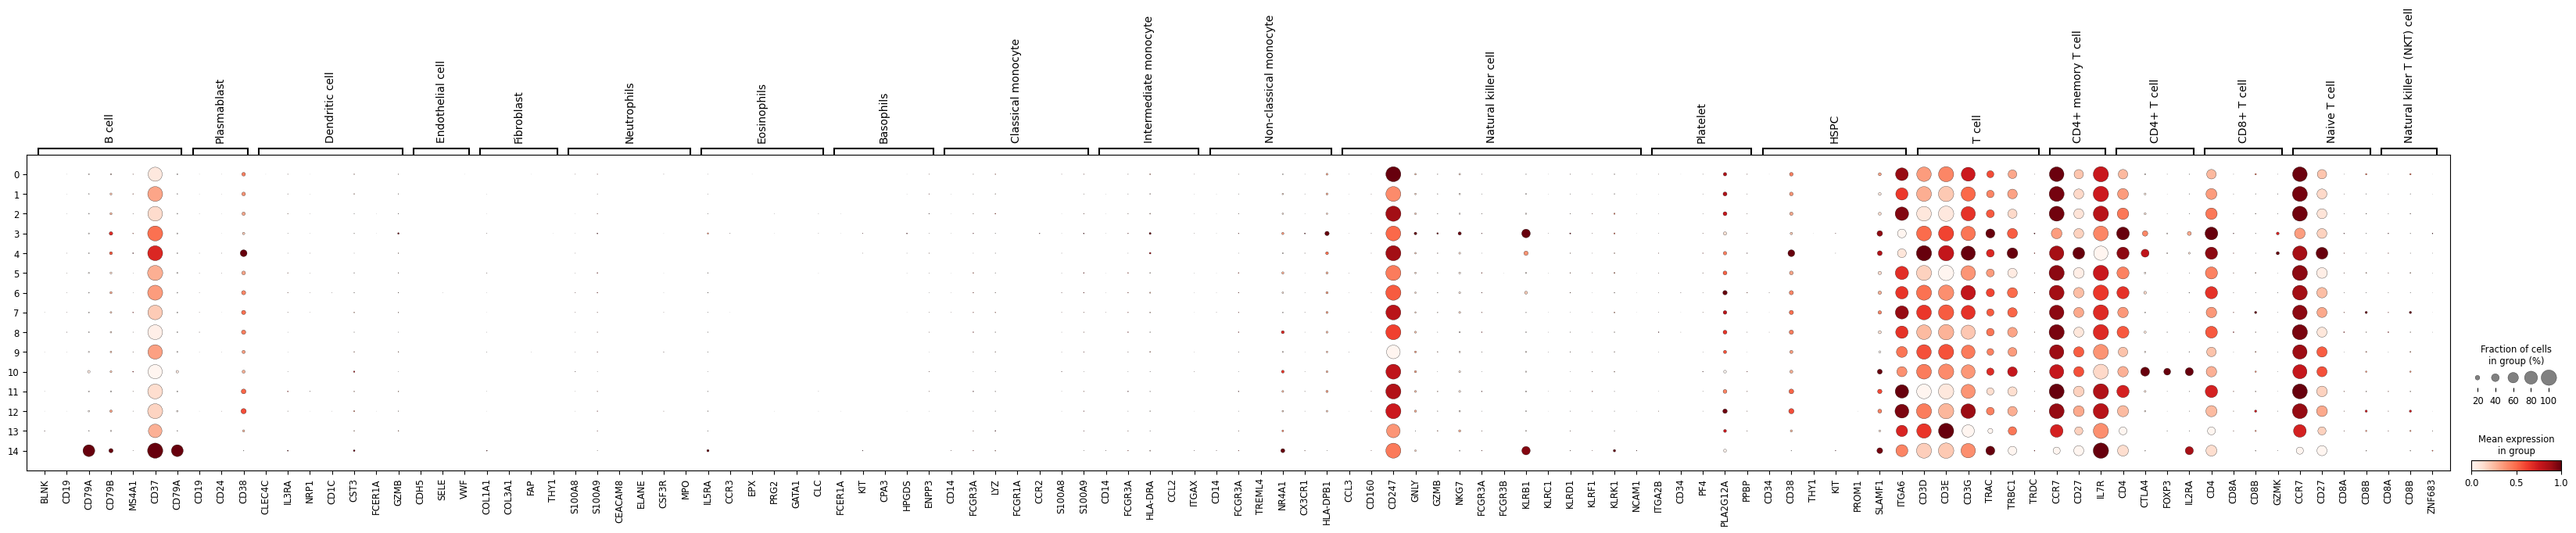

In [52]:
sc.pl.dotplot(raw_adata_cd4, present_marker_genes , groupby="leiden_res_1.0", standard_scale="var", save="_all_markers.png")

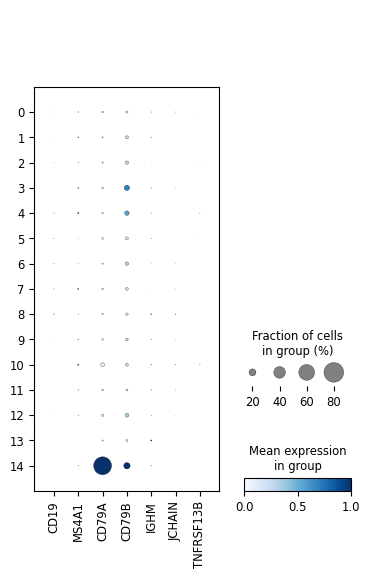

In [53]:
sc.pl.dotplot(raw_adata_cd4, ["CD19", "MS4A1", "CD79A", "CD79B", "IGHM", "JCHAIN", "TNFRSF13B"], groupby="leiden_res_1.0", standard_scale = "var", color_map = "Blues")

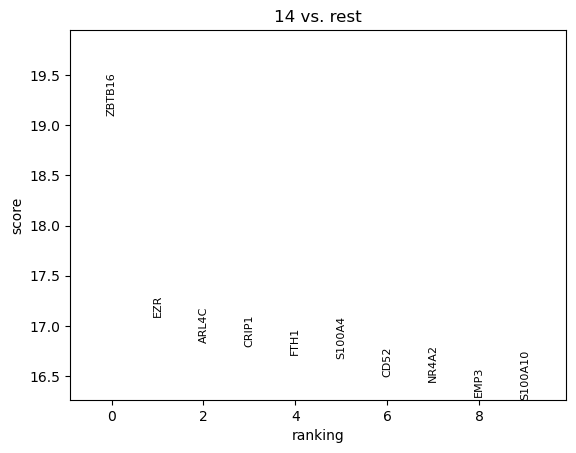

In [54]:
# Cluster 14 looks like B cell
sc.tl.rank_genes_groups(raw_adata_cd4, groupby="leiden_res_1.0", groups=['14'], method="wilcoxon")
sc.pl.rank_genes_groups(raw_adata_cd4, groupby="leiden_res_1.0", n_genes=10)

In [55]:
print(sc.get.rank_genes_groups_df(raw_adata_cd4, group='14').head(30)["names"])

0       ZBTB16
1          EZR
2        ARL4C
3        CRIP1
4         FTH1
5       S100A4
6         CD52
7        NR4A2
8         EMP3
9      S100A10
10       ANXA1
11       AHNAK
12       CD79A
13         FOS
14     LRRFIP1
15        IL32
16         CR1
17    SH3BGRL3
18      CSRNP1
19        SRGN
20     TAMALIN
21      PIK3R1
22        CCR4
23      ZNF331
24       DUSP1
25       CLIC1
26        TPM3
27      ADAM19
28       FXYD5
29       PRKD3
Name: names, dtype: object

saving figure to file /Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation/umap_cluster14_marker_overlays.png


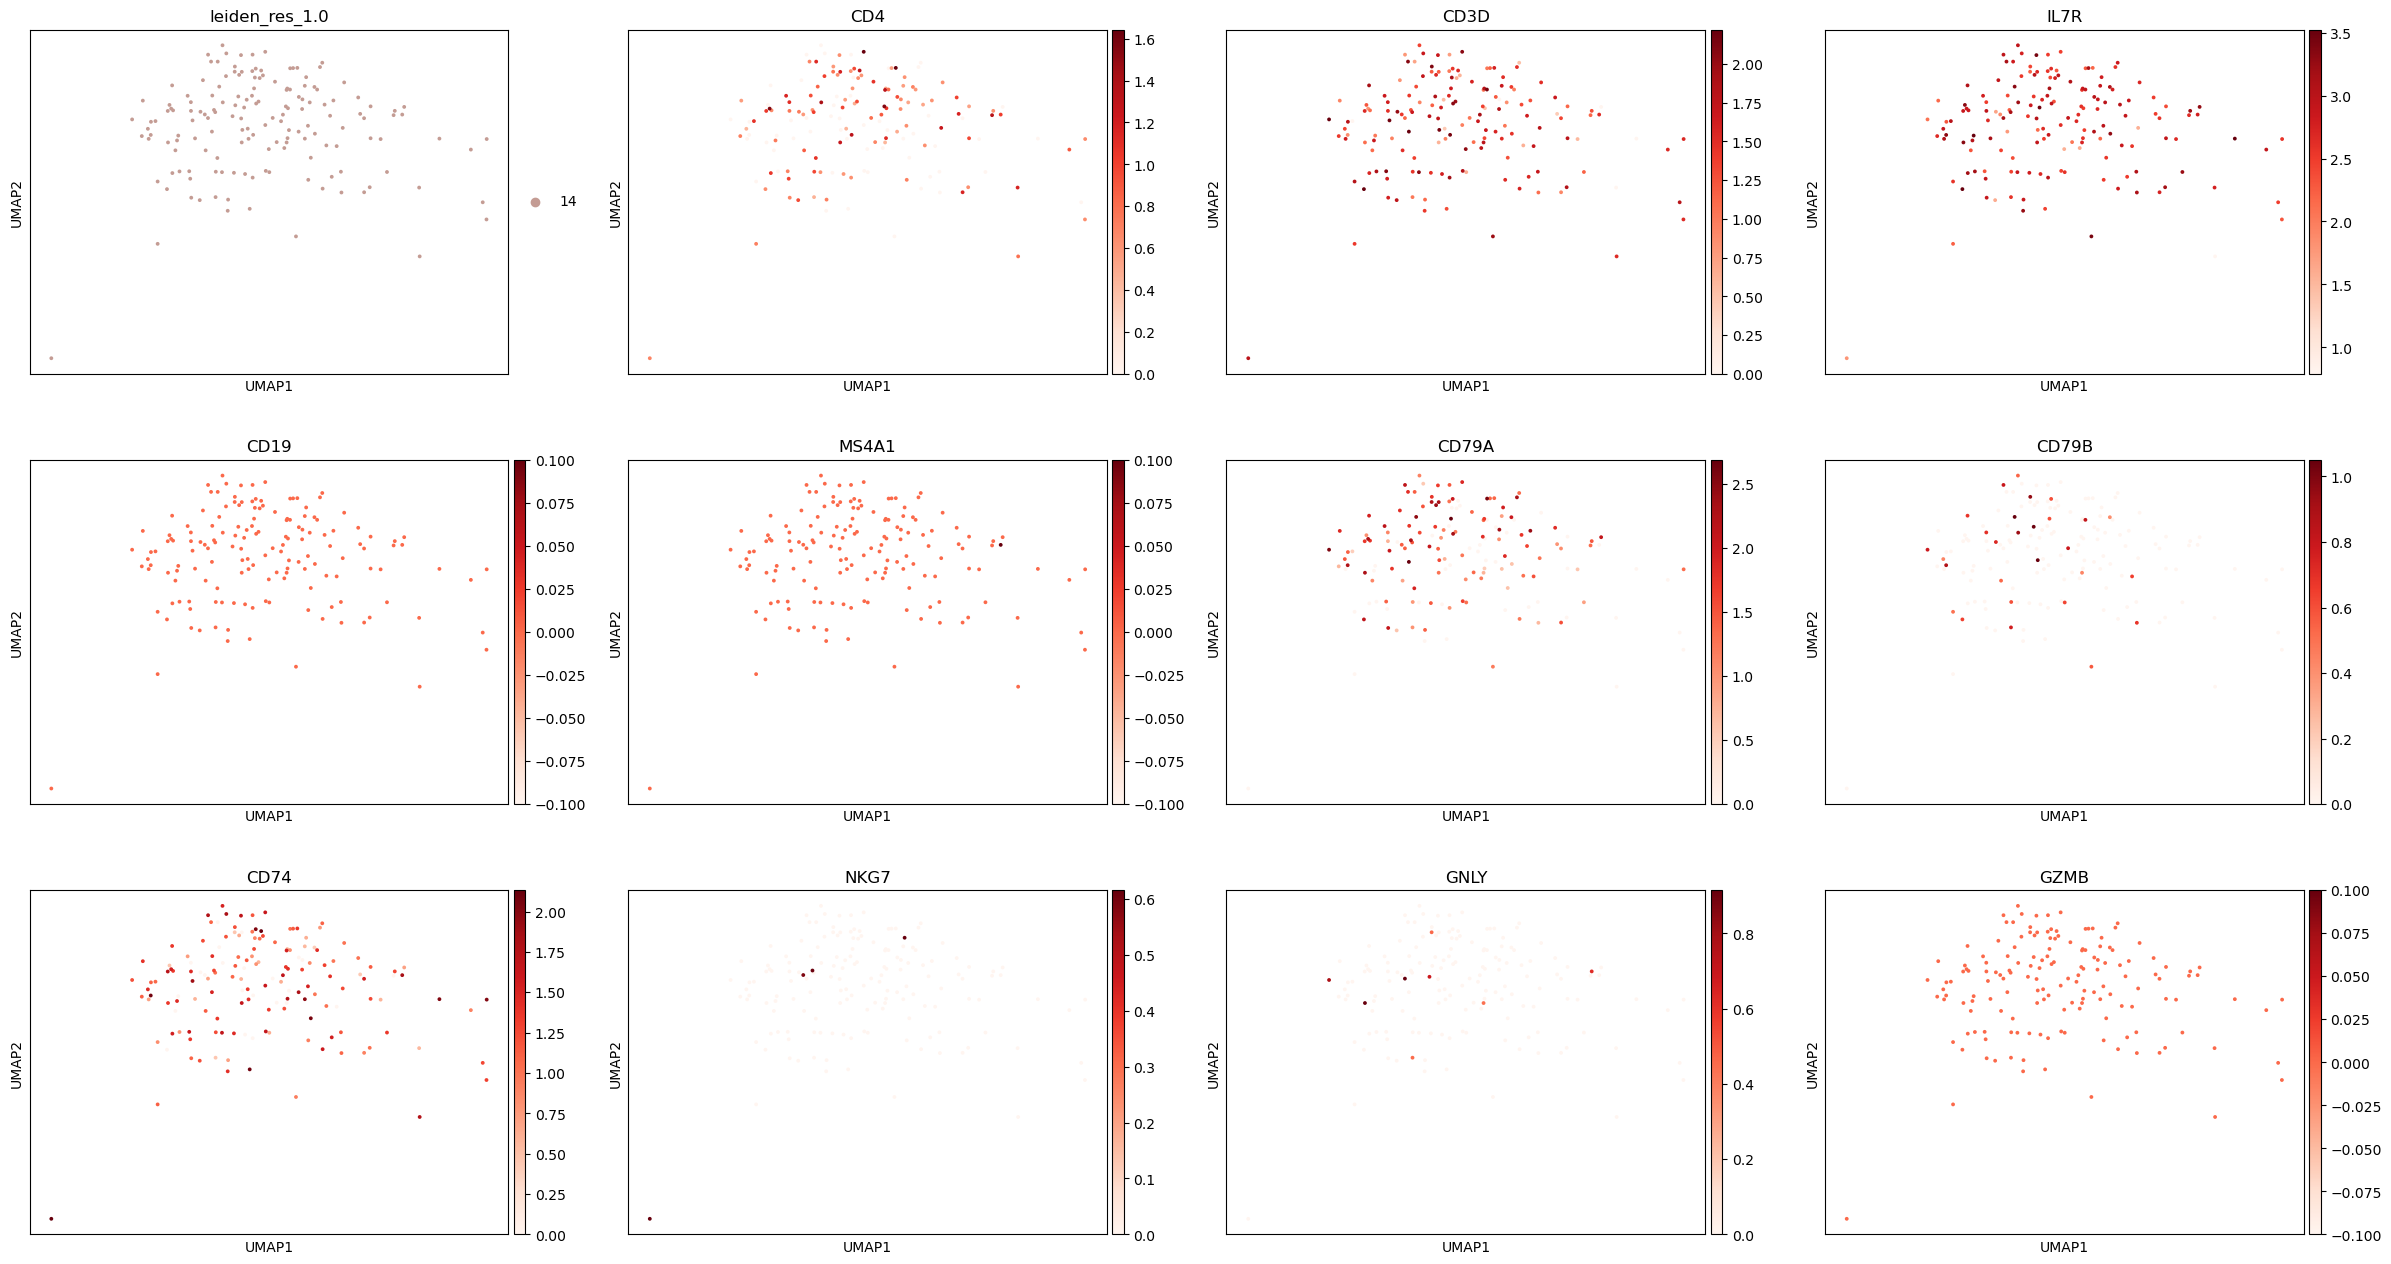

In [56]:
# check core marker expression overlays for cluster 11
cluster_14_cells = raw_adata_cd4[raw_adata_cd4.obs['leiden_res_1.0'] == '14']
sc.pl.umap(
    cluster_14_cells,
    color=["leiden_res_1.0","CD4","CD3D","IL7R",     # CD4 T markers
           'CD19',"MS4A1","CD79A","CD79B","CD74", # B cell markers
           "NKG7","GNLY","GZMB"],   # NK / cytotoxic markers
    vmax="p99",
    cmap="Reds",
    size=30,
    save="_cluster14_marker_overlays.png"
)

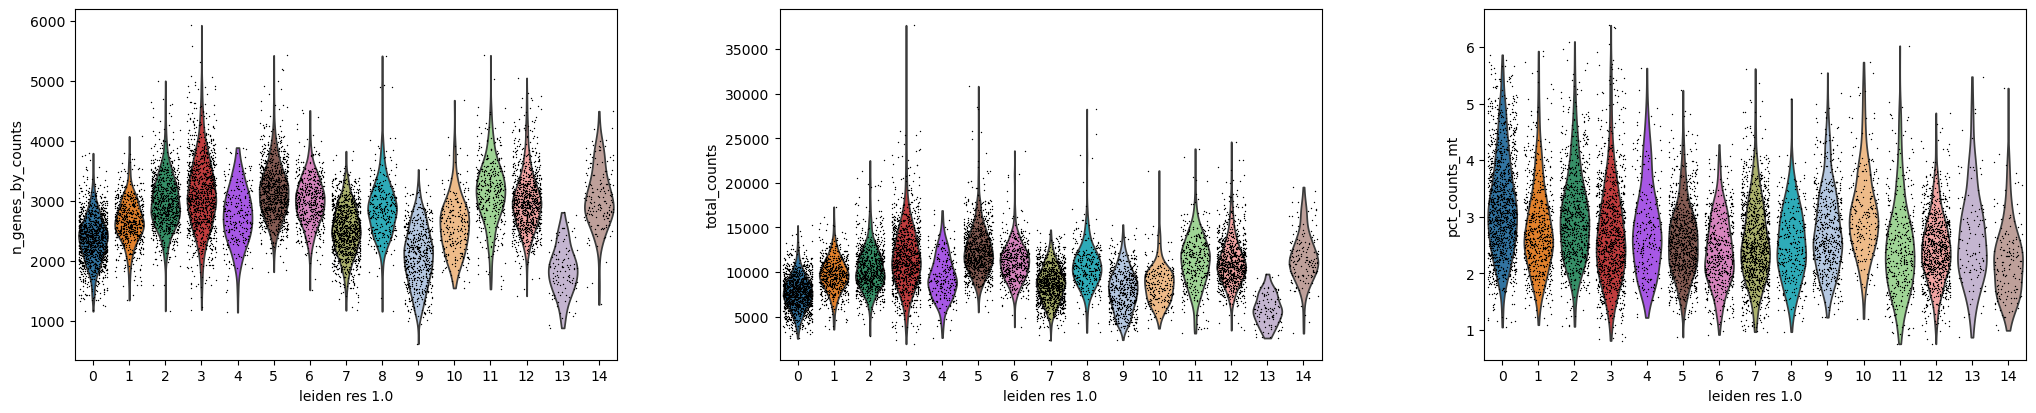

In [57]:
sc.pl.violin(raw_adata_cd4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= 'leiden_res_1.0', jitter=0.4, multi_panel=True)

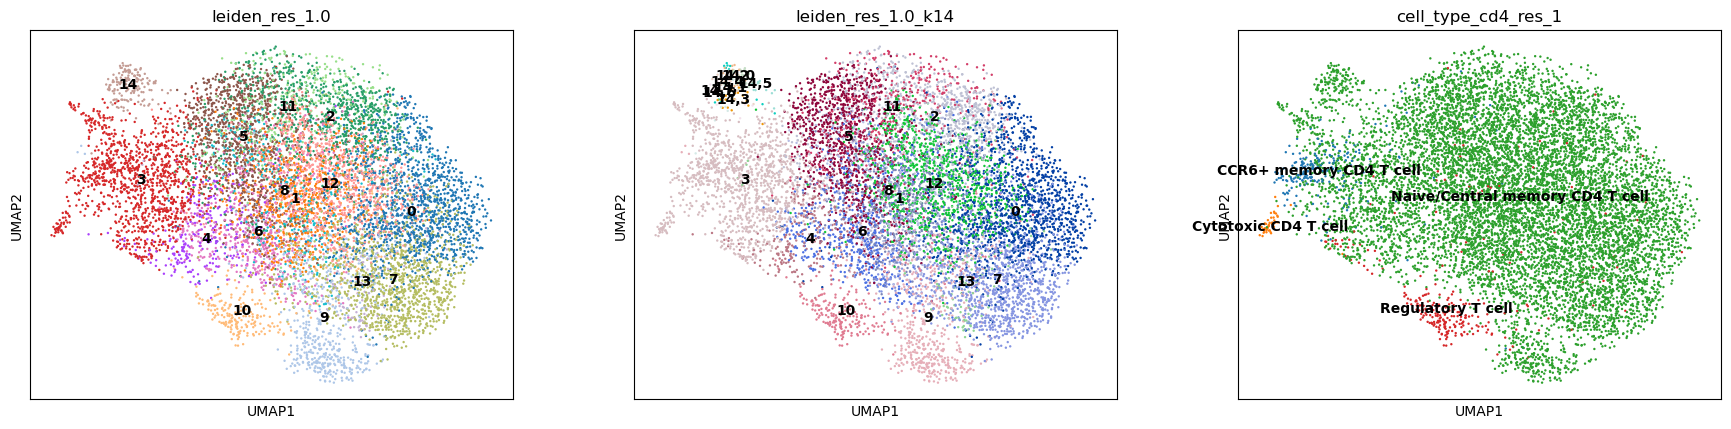

In [58]:
raw_adata_cd4.obs['cell_type_cd4_res_1'] = raw_adata_cd4.obs['cell_type'].copy()
adata_cd4_k14 = raw_adata_cd4.copy()
sc.tl.leiden(adata_cd4_k14, resolution=1.0, restrict_to=('leiden_res_1.0', ['14']), key_added='leiden_res_1.0_k14')
sc.pl.umap(adata_cd4_k14, color=['leiden_res_1.0', 'leiden_res_1.0_k14','cell_type_cd4_res_1'], legend_loc="on data")


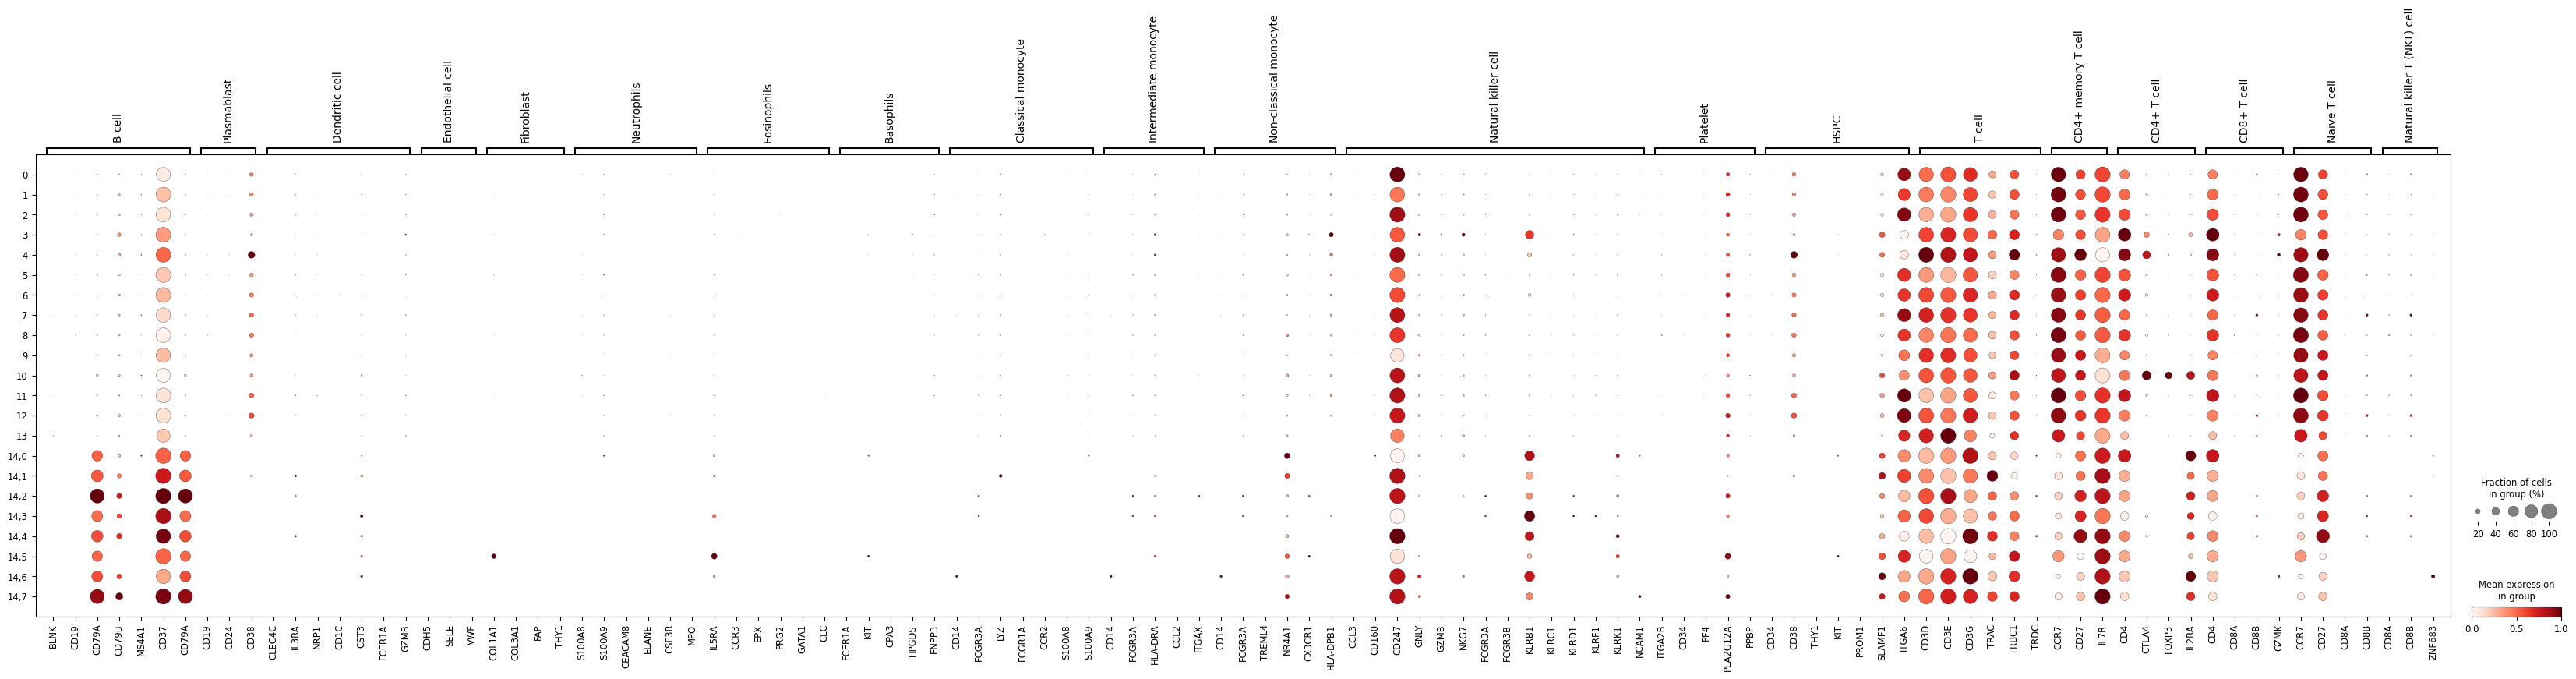

In [59]:
sc.pl.dotplot(adata_cd4_k14, present_marker_genes , groupby="leiden_res_1.0_k14", standard_scale="var")

Cluster 14 exhibited co-expression of canonical B-cell markers (CD79A, CD79B) and pan-T-cell markers (CD3D, CD3E), suggesting the presence of T/B doublets. This hybrid signature, together with its distinct position on the UMAP, indicates technical doublets rather than a true biological subset. Consequently, this cluster was excluded from downstream analysis.

In [60]:
raw_adata_cd4.obs['leiden_res_1.0'] = raw_adata_cd4.obs['leiden_res_1.0'].astype(str)
raw_adata_cd4 = raw_adata_cd4[raw_adata_cd4.obs['leiden_res_1.0'] != '14', :].copy()


In [61]:
raw_adata_cd4.obs['cell_type_cd4_res_1'].value_counts()

cell_type_cd4_res_1
Naive/Central memory CD4 T cell    9372
Regulatory T cell                   267
CCR6+ memory CD4 T cell             221
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

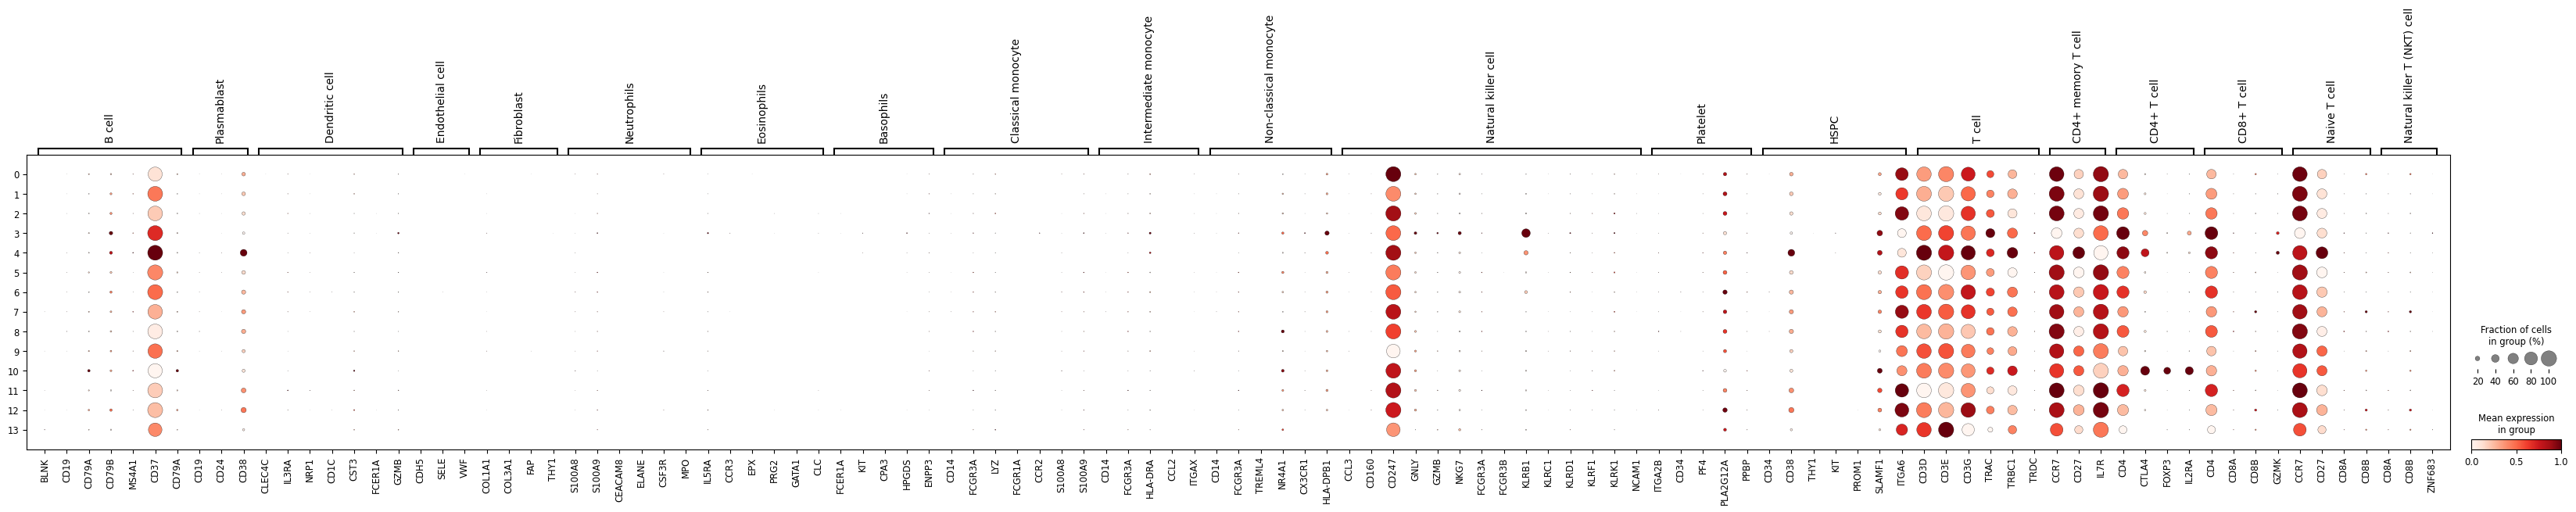

In [62]:
sc.pl.dotplot(raw_adata_cd4,present_marker_genes , groupby="leiden_res_1.0", standard_scale="var")

In [63]:
# save data without cluster 14
raw_adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed.h5ad", compression='gzip')


In [64]:
adata_cd4= sc.read_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed.h5ad")
adata_cd4.var_names_make_unique()
print(adata_cd4)

AnnData object with n_obs × n_vars = 9903 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden_res_0.5', 'leiden_res_0.5_colors', 
'leiden_res_1.0', 'leiden_res_1.0_colors', 'leiden_res_1.5', 'leiden_res_1.5_colors', 'leiden_res_2.0', 
'leiden_res_2.0_colors', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [65]:
# run scvi again
scvi.model.SCVI.setup_anndata(adata_cd4, layer="counts", batch_key="pica_id")
model_clean = scvi.model.SCVI(adata_cd4, n_layers=2, n_latent=30, gene_likelihood="nb")

In [66]:
model_clean.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [2:52:36<00:00, 29.48s/it, v_num=1, train_loss_step=7.81e+3, train_loss_epoch=7.8e+3]   

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [2:52:36<00:00, 25.89s/it, v_num=1, train_loss_step=7.81e+3, train_loss_epoch=7.8e+3]


saving figure to file /Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation/umap_scvi_integrated_umap.png


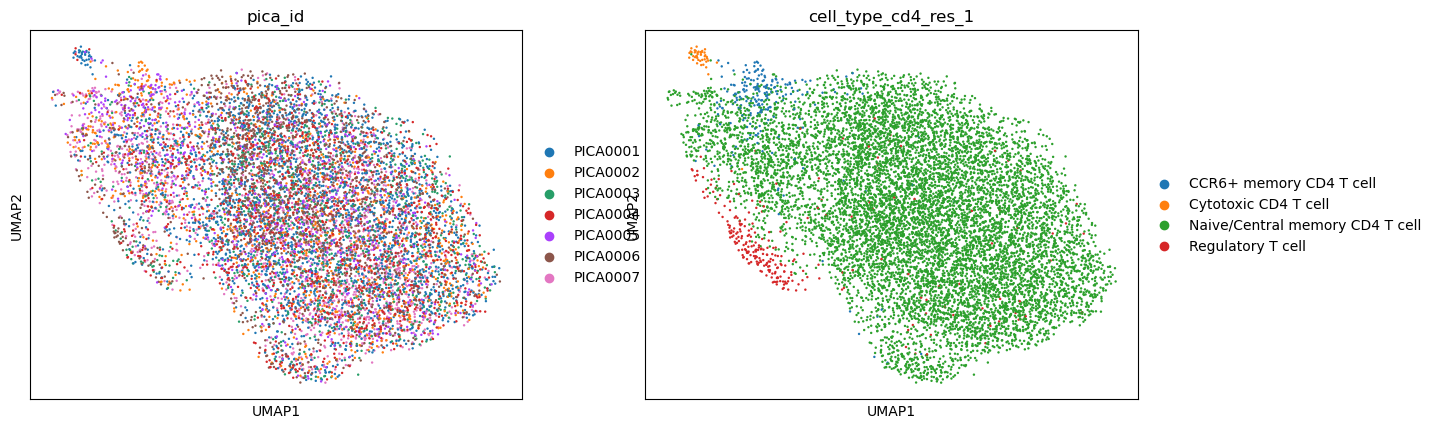

In [78]:
adata_cd4.obsm["X_scVI"] = model_clean.get_latent_representation()

#  latent representation 
sc.pp.neighbors(adata_cd4, use_rep="X_scVI")
sc.tl.umap(adata_cd4)


sc.pl.umap(adata_cd4, color=[ "pica_id", 'cell_type_cd4_res_1'], save="_scvi_integrated_umap.png")

saving figure to file /Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation/umap_scvi_qc.png


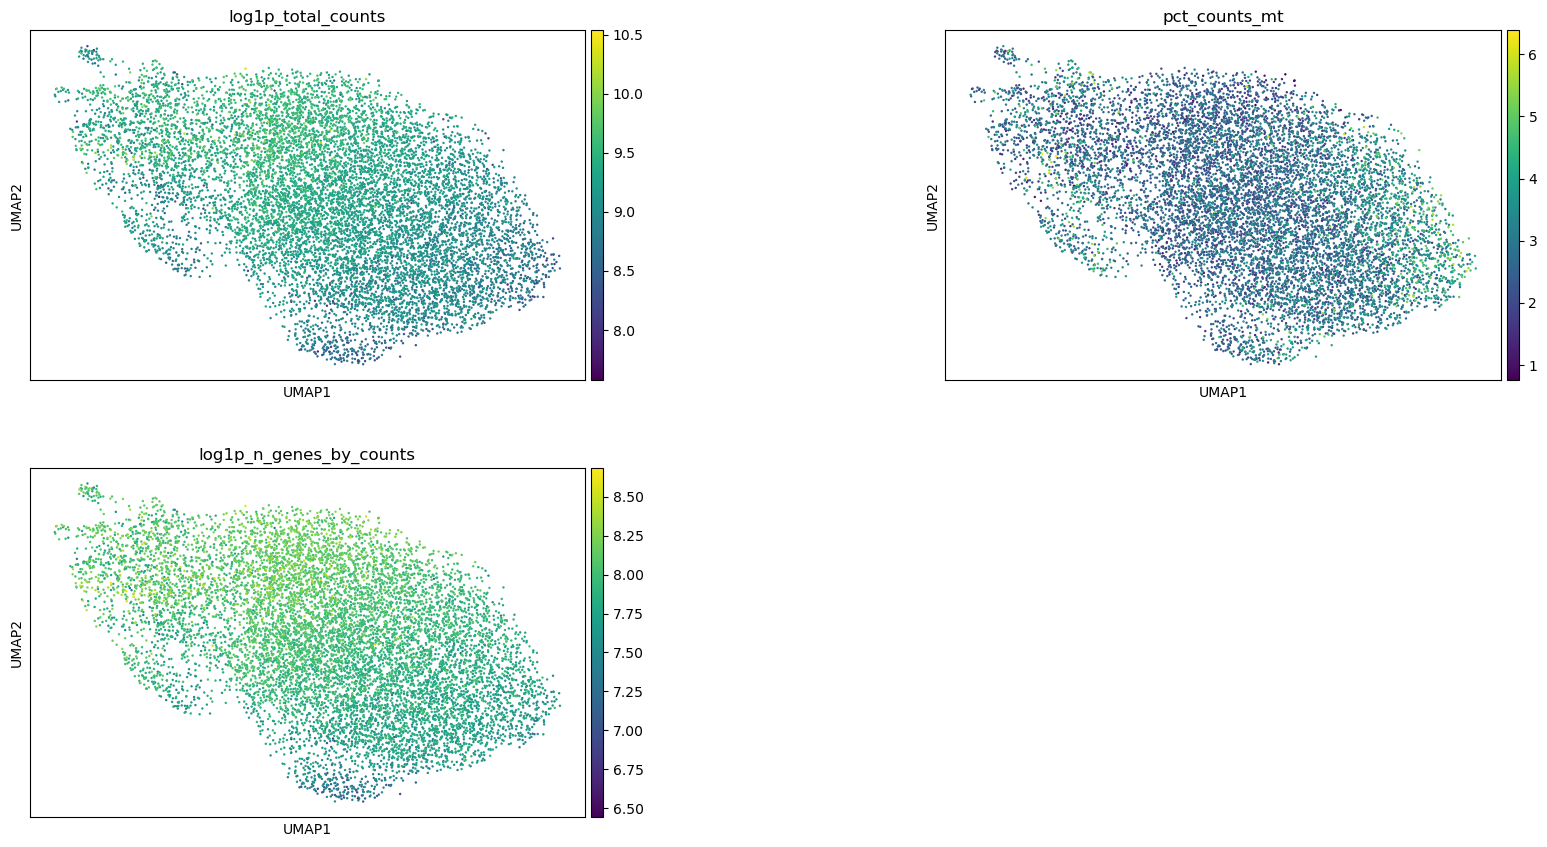

In [79]:
sc.pl.umap(
    adata_cd4,
    color=["log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    save="_scvi_qc.png"
)

In [80]:
# Save the scVI integrated batch adata
adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_scVI.h5ad", compression='gzip')

In [81]:
# clustering
for res in [ 0.5, 1.0, 1.5, 2.0]:
    sc.tl.leiden(
        adata_cd4, key_added=f"leiden_res_{res:3.1f}", resolution=res, flavor="igraph"
    )

In [82]:
keys = ["leiden_res_0.5", "leiden_res_1.0", "leiden_res_1.5", "leiden_res_2.0"]


for k in keys:
    if k in adata_cd4.obs:
        # ensure categorical and drop removed labels
        adata_cd4.obs[k] = adata_cd4.obs[k].astype("category").cat.remove_unused_categories()
        # drop stale palette so Scanpy creates a new one with correct length
        ckey = f"{k}_colors"
        if ckey in adata_cd4.uns:
            del adata_cd4.uns[ckey]

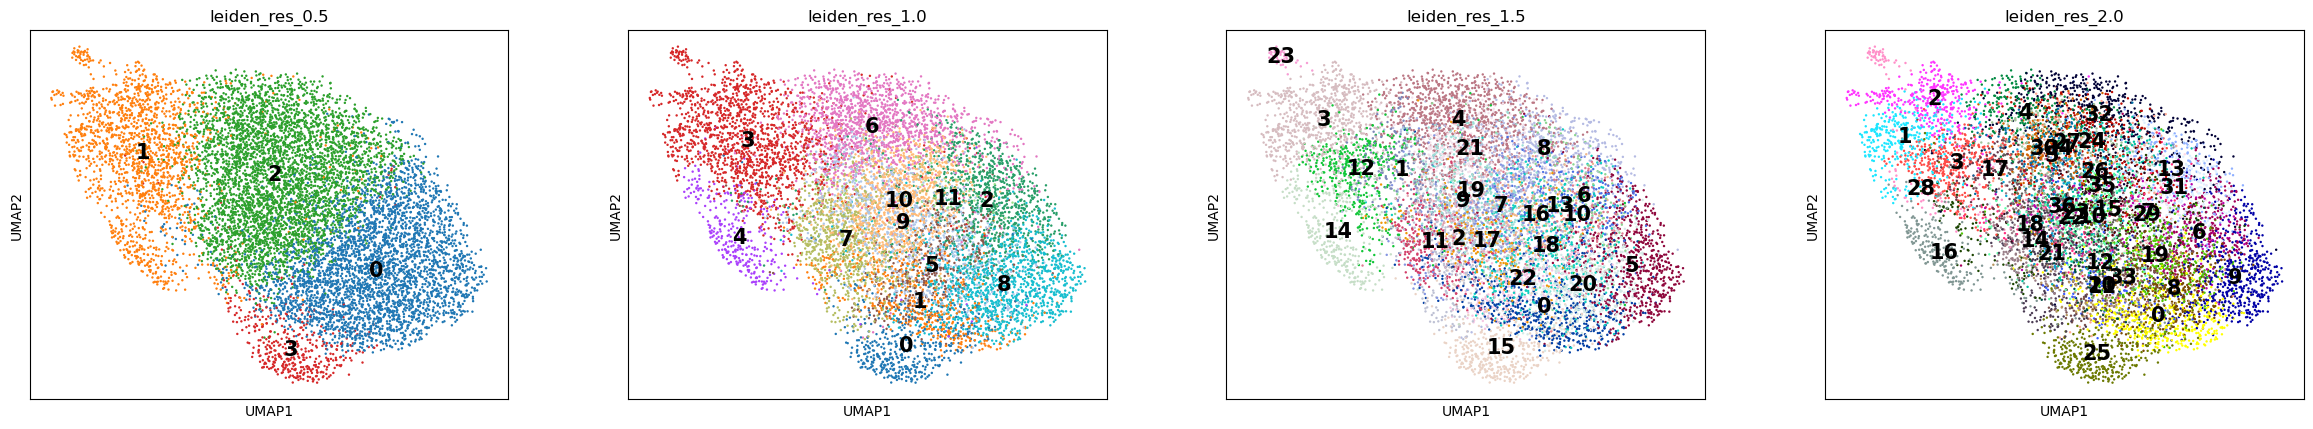

In [83]:
sc.pl.umap(
    adata_cd4,
    color=[ "leiden_res_0.5", "leiden_res_1.0","leiden_res_1.5", "leiden_res_2.0"],
    legend_loc="on data", legend_fontsize = 15
)

In [84]:
adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_cluster.h5ad", compression='gzip')
print(adata_cd4)

AnnData object with n_obs × n_vars = 9903 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden_res_0.5', 'leiden_res_1.0', 
'leiden_res_1.5', 'leiden_res_2.0', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'rank_genes_groups', 'umap', 
'cell_type_cd4_res_1_colors', 'leiden_res_0.5_colors', 'leiden_res_1.0_colors', 'leiden_res_1.5_colors', 
'leiden_res_2.0_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

saving figure to file /Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation/dotplot__all_markers.png


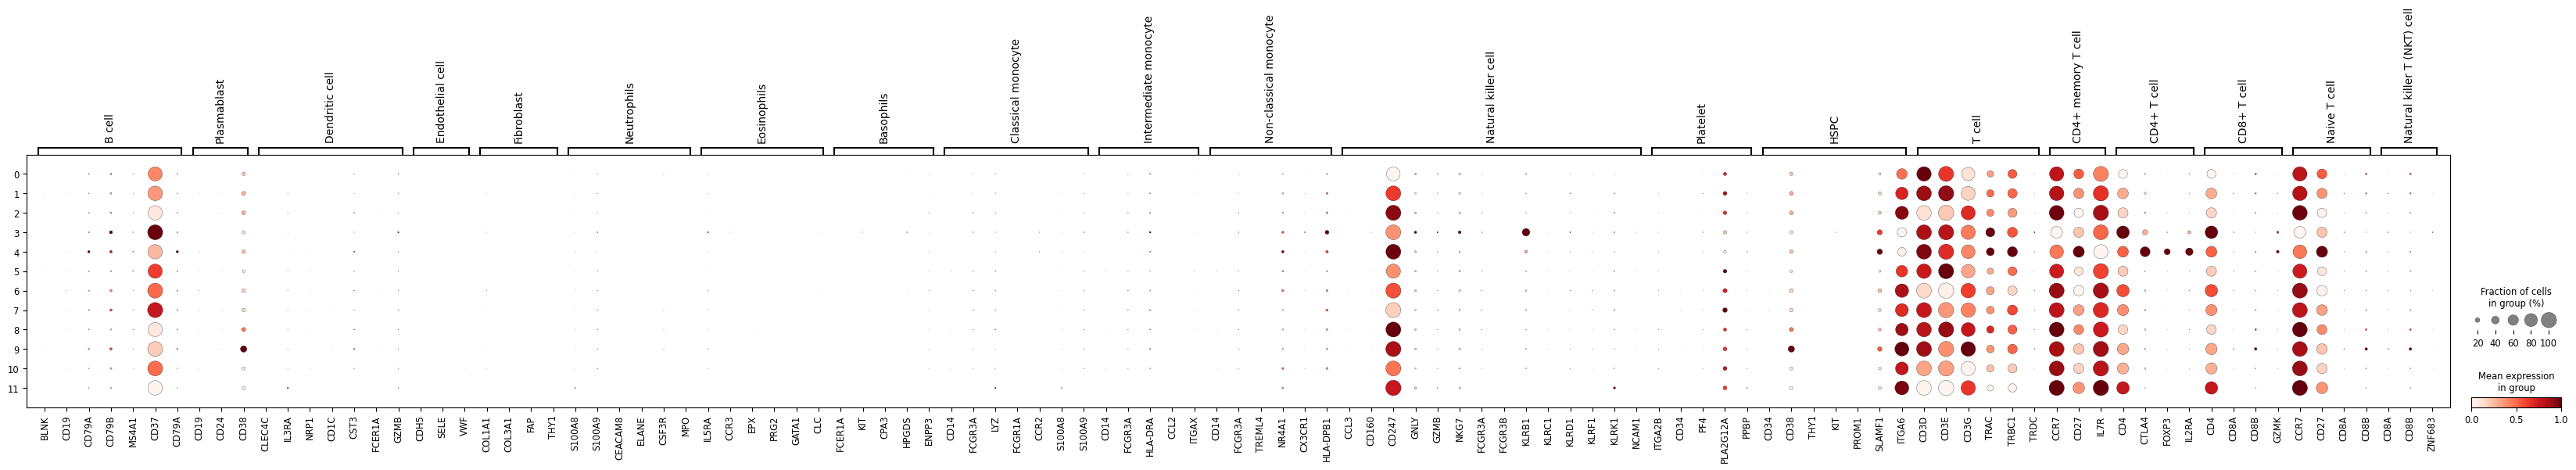

In [85]:
sc.pl.dotplot(adata_cd4, present_marker_genes , groupby="leiden_res_1.0", standard_scale="var", save="_all_markers.png")

In [86]:
adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_cd4_annotations.h5ad", compression='gzip')
print(adata_cd4)

AnnData object with n_obs × n_vars = 9903 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'leiden_res_0.5', 'leiden_res_1.0', 
'leiden_res_1.5', 'leiden_res_2.0', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'rank_genes_groups', 'umap', 
'cell_type_cd4_res_1_colors', 'leiden_res_0.5_colors', 'leiden_res_1.0_colors', 'leiden_res_1.5_colors', 
'leiden_res_2.0_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'